In [580]:
%matplotlib inline

from difflib import SequenceMatcher

import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

In [348]:
rym_top_500 = pd.read_csv("../data/rym_top_500_albums.tsv", sep="\t", index_col=0)
rym_top_500.head()

,album_id,artist,name,date,genres,rating,num_ratings,num_reviews
position,,,,,,,,
1,Album45,Radiohead,Ok Computer,1997,"Alternative Rock, Art Rock",4.23,60527,1583
2,Album46,Radiohead,Kid A,2000,"Art Rock, Experimental Rock, Electronic",4.23,50279,714
3,Album976,Pink Floyd,The Dark Side Of The Moon,1973,"Art Rock, Progressive Rock",4.23,50633,1524
4,Album974,Pink Floyd,Wish You Were Here,1975,"Progressive Rock, Art Rock",4.29,41760,939
5,Album2328,King Crimson,In The Court Of The Crimson King,1969,"Progressive Rock, Art Rock",4.31,37873,828


In [412]:
rs_top_500 = pd.read_csv("../data/rs_top_500_albums.tsv", sep="\t", index_col=0)
rs_top_500 = rs_top_500.replace(19755, 1975) # site has one entry as 19755
print(rs_top_500.shape)
rs_top_500.head()

(500, 3)


,artist,name,date
position,,,
1,Marvin Gaye,What'S Going On,1971
2,The Beach Boys,Pet Sounds,1966
3,Joni Mitchell,Blue,1971
4,Stevie Wonder,Songs In The Key Of Life,1976
5,The Beatles,Abbey Road,1969


In [400]:
rs_top_500[rs_top_500["artist"] == "Brian Eno"]

,artist,name,date
position,,,
308,Brian Eno,Here Come The Warm Jets,1974
338,Brian Eno,Another Green World,19755


In [351]:
rym_album_set = set([tuple(row[["artist", "name"]]) for i, row in rym_top_500.iterrows()])
rs_album_set = set([tuple(row[["artist", "name"]]) for i, row in rs_top_500.iterrows()])

In [340]:
both_album_set = rym_album_set.intersection(rs_album_set)
print(len(both_album_set))

157


In [297]:
rym_only = rym_album_set.difference(rs_album_set)
rs_only = rs_album_set.difference(rym_album_set)
print(len(rym_only))
print(len(rs_only))

343
343


Look for albums that are very close to each other.

In [332]:
# create similarity matrix
# rows: rolling stones
# columns: rym
sim_mat = np.zeros([len(rs_only), len(rym_only), 2])
for i, rs_album in enumerate(rs_only):
    for j, rym_album in enumerate(rym_only):
        # sort by decreasing length
        #lambda x: len(x)
        #rs_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        #rym_album = sorted(rs_album, key=lambda x: len(x), reverse=True)
        
        artist_ratio = SequenceMatcher(None, rs_album[0], rym_album[0]).ratio()
        if artist_ratio >= 0.4 and (rs_album[0] in rym_album[0] or rym_album[0] in rs_album[0]):
            artist_ratio = 1.0
        
        album_ratio = SequenceMatcher(None, rs_album[1], rym_album[1]).ratio()
        if album_ratio >= 0.4 and (rs_album[1] in rym_album[1] or rym_album[1] in rs_album[1]):
            album_ratio = 1.0          
        
        sim_mat[i][j][0] = artist_ratio
        sim_mat[i][j][1] = album_ratio

In [302]:
sim_mat[:, :, 0].shape

(343, 343)

In [333]:
artist_sim_df = pd.DataFrame(sim_mat[:, :, 0])
artist_sim_df.index = rs_only
artist_sim_df.columns = rym_only

album_sim_df = pd.DataFrame(sim_mat[:, :, 1])
album_sim_df.index = rs_only
album_sim_df.columns = rym_only

In [328]:
artist_album_sims = sim_mat.reshape([343*343, 2])
artist_album_sims[:,0]


array([0.2       , 0.17142857, 0.11428571, ..., 0.2962963 , 0.08695652,
       0.        ])

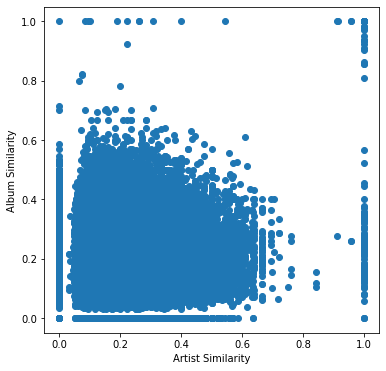

In [364]:
artist_album_sims = sim_mat.reshape([len(rs_only)**2, 2])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(
    x=artist_album_sims[:, 0],
    y=artist_album_sims[:, 1],
    #ax=ax,
)

ax.set_xlabel("Artist Similarity")
ax.set_ylabel("Album Similarity")

plt.show()

Look for entries w/ artist similarity > 0.6 & artist similarity > 0.6

In [355]:
album_id_combos = list(zip(*np.where((sim_mat[:, :, 0] >= 0.5) & (sim_mat[:, :, 1] >= 0.7))))
album_combos = [(list(rs_only)[i], list(rym_only)[j], sim_mat[i, j, 0], sim_mat[i, j, 1]) for i, j in album_id_combos]
for x in sorted(album_combos, key=lambda x: np.mean(x[2:4])): print(x)
print(len(album_combos))

(('BjöRk', 'Post'), ('Björk', 'Post'), 0.5454545454545454, 1.0)
(('Weezer', 'Weezer (The Blue Album)'), ('Weezer', 'Weezer [Blue Album]'), 1.0, 0.8095238095238095)
(('Elliott Smith', 'Either\\/Or'), ('Elliott Smith', 'Either / Or'), 1.0, 0.8571428571428571)
(('Prince', "Sign O' The Times"), ('Prince', 'Sign "☮" The Times'), 1.0, 0.8571428571428571)
(('The Rolling Stones', 'Exile On Main Street'), ('The Rolling Stones', 'Exile On Main St.'), 1.0, 0.8648648648648649)
(('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129)
(('Can', 'Ege Bamyasi'), ('Can', 'Ege Bamyası'), 1.0, 0.9090909090909091)
(('Sly And The Family Stone', "There'S A Riot Goin' On"), ('Sly & The Family Stone', "There'S A Riot Goin' On"), 0.9130434782608695, 1.0)
(('Crosby, Stills, Nash, And Young', 'Déjà Vu'), ('Crosby, Stills, Nash & Young', 'Déjà Vu'), 0.9152542372881356, 1.0)
(('New Order', 'Power, Corruption &Amp; Lies'), ('New Order', 'Power, Corruption & Lies'), 1.0, 0

In [356]:
album_combos.remove((('Led Zeppelin', 'Led Zeppelin Iv'), ('Led Zeppelin', 'Led Zeppelin Iii'), 1.0, 0.9032258064516129))

In [360]:
final_both_album_set = both_album_set.union(set([x[1] for x in album_combos]))
final_rym_only_set = rym_only.copy()
final_rs_only_set = rs_only.copy()

for combo in album_combos:
    final_rym_only_set.remove(combo[1])
    final_rs_only_set.remove(combo[0])

print(len(final_both_album_set))
print(len(final_rs_only_set))
print(len(final_rym_only_set))

192
308
308


In [363]:
final_both_album_set

{('A Tribe Called Quest', 'Midnight Marauders'),
 ('A Tribe Called Quest', 'The Low End Theory'),
 ('Alice Coltrane Featuring Pharoah Sanders', 'Journey In Satchidananda'),
 ('Arcade Fire', 'Funeral'),
 ('Beastie Boys', "Paul'S Boutique"),
 ('Belle And Sebastian', "If You'Re Feeling Sinister"),
 ('Björk', 'Homogenic'),
 ('Björk', 'Post'),
 ('Black Sabbath', 'Black Sabbath'),
 ('Black Sabbath', 'Master Of Reality'),
 ('Black Sabbath', 'Paranoid'),
 ('Bob Dylan', 'Blonde On Blonde'),
 ('Bob Dylan', 'Blood On The Tracks'),
 ('Bob Dylan', 'Bringing It All Back Home'),
 ('Bob Dylan', 'Highway 61 Revisited'),
 ('Bob Dylan', "The Freewheelin' Bob Dylan"),
 ('Bob Marley', 'Exodus'),
 ('Bon Iver', 'For Emma, Forever Ago'),
 ('Bruce Springsteen', 'Born To Run'),
 ('Bruce Springsteen', 'Darkness On The Edge Of Town'),
 ('Bruce Springsteen', 'Nebraska'),
 ('Can', 'Ege Bamyası'),
 ('Charles Mingus', 'Mingus Ah Um'),
 ('Cocteau Twins', 'Heaven Or Las Vegas'),
 ('Creedence Clearwater Revival', "Cosmo

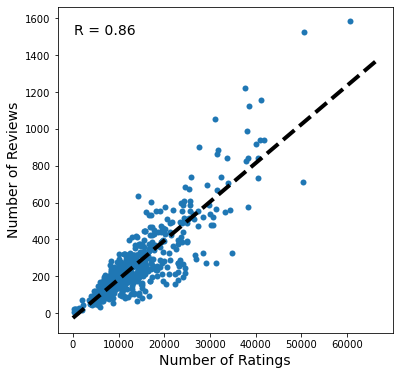

In [365]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

_regression = ss.linregress(
    rym_top_500["num_ratings"],
    rym_top_500["num_reviews"],
)

sns.scatterplot(
    data=rym_top_500,
    x="num_ratings",
    y="num_reviews",
    linewidth=0,
    ax=ax,
)

x = np.arange(0, rym_top_500["num_ratings"].max()*1.1)
y = _regression.slope*x + _regression.intercept

ax.plot(x, y, linewidth=4, linestyle="--", zorder=1, color="black")
ax.text(
    x=0.05,
    y=0.95,
    ha="left",
    va="top",
    s=f"R = {round(_regression.rvalue, 3)}",
    fontsize=14,
    transform=ax.transAxes
)

ax.set_xlabel("Number of Ratings", fontsize=14)
ax.set_ylabel("Number of Reviews", fontsize=14)

plt.show()

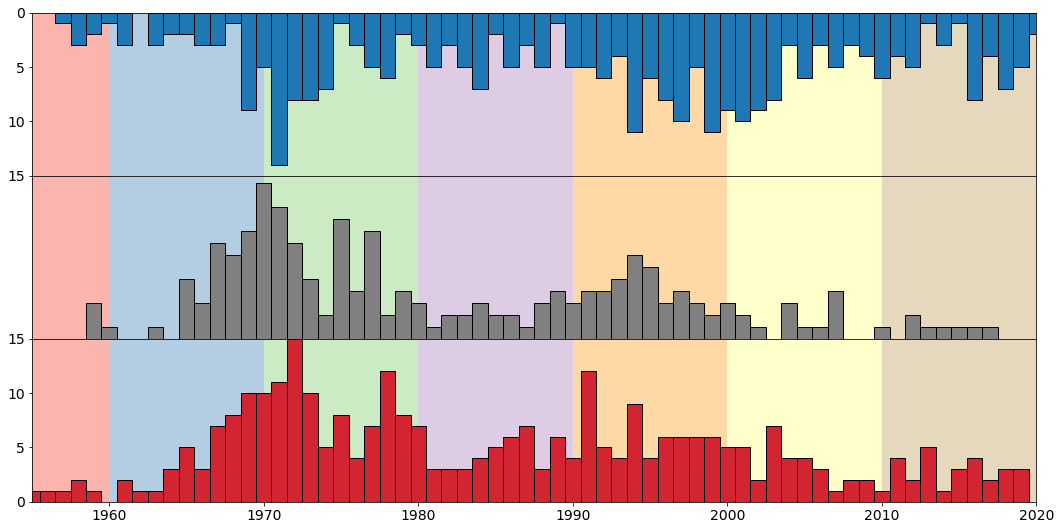

In [633]:
fig = plt.figure(figsize=(18, 9))
heights = [5, 5, 5]
spec = fig.add_gridspec(nrows=3, ncols=1, height_ratios=heights)

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])

plt.subplots_adjust(hspace=0.0)

min_year = min(rym_top_500["date"].min(), rs_top_500["date"].min())
max_year = max(rym_top_500["date"].max(), rs_top_500["date"].max())

# rym only
_df1 = rym_top_500.copy()
_df1["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df1.iterrows()]
_df1 = _df1[_df1["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
_df1 = _df1["date"].value_counts().to_frame().reset_index()

#ax1.hist(_df1["date"], bins=max_year-min_year, bottom=0)
ax1.bar(_df1["index"], _df1["date"], width=1, edgecolor="black")
ax1.set_ylim([0, 15])
ax1.set_yticks(np.arange(0, 16, 5))
ax1.invert_yaxis()
ax1.xaxis.set_visible(False)

bg_palette = sns.color_palette("Pastel1", 7)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim([min_year, max_year])
    #ax.set_xticks(np.arange(min_year, max_year+1))
    for i, yr in enumerate(np.arange(round(min_year/10)*10-10, round(max_year/10)*10, 10)):
        #ax.axvline(x=yr, zorder=0, linestyle="--", color="black")
        ax.axvspan(yr, yr+10, facecolor=bg_palette[i], zorder=0)
        pass

# rolling stones only
_df2 = rs_top_500.copy()
_df2["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df2.iterrows()]
_df2 = _df2[_df2["artist_name"].isin(["_".join(x) for x in final_rs_only_set])]
_df2 = _df2["date"].value_counts().to_frame().reset_index()

ax3.bar(_df2["index"], _df2["date"], width=1, color="#d32531", edgecolor="black")
ax3.set_ylim([0, 15])
ax3.set_yticks(np.arange(0, 16, 5))
ax3.tick_params("both", labelsize=14)

# middle
_df3 = rym_top_500.copy()
_df3["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df3.iterrows()]
_df3 = _df3[_df3["artist_name"].isin(["_".join(x) for x in final_both_album_set])]
_df3 = _df3.groupby(["date"]).size().to_frame()
_df3 = _df3.rename(columns={0: "count"})
_df3 = _df3.reset_index()

ax2.bar(_df3["date"], _df3["count"], width=1, color="gray", edgecolor="black")

#ax2.set_ylim([0, 5])
#ax2.set_xlim([0, 65])
#ax2.axis("equal")
"""
for i, row in _df3.iterrows():
    p = mpatches.Circle(
        (row["date"], ax2.get_ylim()[1]/2),
        radius=row["radius"],
        facecolor="darkgray",
        edgecolor="black",
    )
    ax2.add_patch(p)
"""

ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
    
for ax in [ax1, ax3]:
    ax.tick_params("y", labelsize=14)
    #ax.set_ylabel("# Albums", fontsize=18)

plt.show()

In [628]:
_df3

,date,count
0,1959,3
1,1960,1
2,1963,1
3,1965,5
4,1966,3
5,1967,8
6,1968,7
7,1969,9
8,1970,13
9,1971,11


In [527]:
ax2.get_ylim()

(-0.05500000000000001, 0.05500000000000001)

In [440]:
_df2[_df2["date"] == 1971]

,artist,name,date,artist_name
position,,,,
25,Carole King,Tapestry,1971,Carole King_Tapestry
105,The Allman Brothers,At Fillmore East,1971,The Allman Brothers_At Fillmore East
149,John Prine,John Prine,1971,John Prine_John Prine
177,Rod Stewart,Every Picture Tells A Story,1971,Rod Stewart_Every Picture Tells A Story
223,John Lennon,Imagine,1971,John Lennon_Imagine
257,Dolly Parton,Coat Of Many Colors,1971,Dolly Parton_Coat Of Many Colors
259,Janis Joplin,Pearl,1971,Janis Joplin_Pearl
281,Harry Nilsson,Nilsson Schmilsson,1971,Harry Nilsson_Nilsson Schmilsson
304,Bill Withers,Just As I Am,1971,Bill Withers_Just As I Am


In [420]:
_df = rym_top_500.copy()
_df["artist_name"] = ["_".join(x[["artist", "name"]].tolist()) for i, x in _df.iterrows()]
_df = _df[_df["artist_name"].isin(["_".join(x) for x in final_rym_only_set])]
print(_df.shape)
_df.head()

(308, 9)


,album_id,artist,name,date,genres,rating,num_ratings,num_reviews,artist_name
position,,,,,,,,,
5,Album2328,King Crimson,In The Court Of The Crimson King,1969,"Progressive Rock, Art Rock",4.31,37873,828,King Crimson_In The Court Of The Crimson King
13,Album2602,Godspeed You Black Emperor!,Lift Yr. Skinny Fists Like Antennas To Heaven!,2000,Post-Rock,4.17,29742,586,Godspeed You Black Emperor!_Lift Yr. Skinny Fi...
21,Album978,Pink Floyd,Animals,1977,"Progressive Rock, Art Rock",4.12,31600,666,Pink Floyd_Animals
31,Album2671,Slint,Spiderland,1991,"Post-Rock, Math Rock, Post-Hardcore",4.15,27345,470,Slint_Spiderland
37,Album6543,King Crimson,Red,1974,"Progressive Rock, Art Rock",4.22,20076,427,King Crimson_Red


In [415]:
max_year

2020

In [390]:
for i, x in _df.iterrows():
    print(x[["artist", "name"]].tolist())
    break

['Marvin Gaye', "What'S Going On"]
